# ResNet through Transfer Leraning

In [2]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.utils import np_utils
from keras import optimizers
from matplotlib import pyplot as plt
from keras.datasets import cifar10
import numpy as np
from keras.callbacks import LearningRateScheduler
from scipy.misc import toimage

Using TensorFlow backend.


c:\users\abhay\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


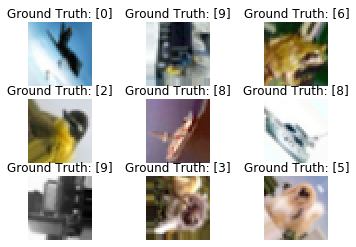

Shape of training data: (50000, 32, 32, 3) (50000, 1)
Shape of testing data: (10000, 32, 32, 3) (10000, 1)


In [3]:
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

datagen = ImageDataGenerator( rotation_range=90,
                 width_shift_range=0.1, height_shift_range=0.1,
                 horizontal_flip=True)
datagen.fit(x_train)

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.axis('off')
        plt.title('Ground Truth: {}'.format(y_batch[i]))
        plt.imshow(toimage(X_batch[i].reshape(32, 32, 3)))
    # show the plot
    plt.show()
    break
    
print("Shape of training data: {} {}".format(x_train.shape,y_train.shape))
print("Shape of testing data: {} {}".format(x_test.shape,y_test.shape))

In [4]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train/255
x_test = x_test/255

# z-score
mean = np.mean(x_train, axis=(0, 1, 2, 3))
std = np.std(x_train, axis=(0, 1, 2, 3))
x_train = (x_train - mean) / (std + 1e-7)
x_test = (x_test - mean) / (std + 1e-7)

num_classes = 10
print(y_train[0])
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)
print(y_train[0])

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

[6]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [5]:
batch_size = 64
epochs = 50

model = ResNet50(input_shape = (32,32,3), include_top = False, weights = 'imagenet')

Instructions for updating:
Colocations handled automatically by placer.


c:\users\abhay\appdata\local\programs\python\python36\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [6]:
for layer in model.layers[:5]:
    layer.trainable = False
    

In [7]:
x = model.output
x = layers.Flatten()(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(1024,activation='relu')(x)
x = layers.Dense(num_classes,activation='softmax')(x)

network = keras.models.Model(model.input,x)
network.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 16, 16, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 16, 16, 64)   256         conv1[0][0]                 

In [8]:
network.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
import timeit

start = timeit.default_timer()

model_train = network.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,validation_split=0.2,callbacks=[LearningRateScheduler(lr_schedule)],verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 325s 8ms/step - loss: 1.9109 - acc: 0.3990 - val_loss: 5.4925 - val_acc: 0.1014
Epoch 2/50
40000/40000 [==============================] - 309s 8ms/step - loss: 1.5036 - acc: 0.4823 - val_loss: 3.3453 - val_acc: 0.0952
Epoch 3/50
40000/40000 [==============================] - 309s 8ms/step - loss: 1.1287 - acc: 0.6039 - val_loss: 3.5495 - val_acc: 0.1015
Epoch 4/50
40000/40000 [==============================] - 309s 8ms/step - loss: 1.1181 - acc: 0.6142 - val_loss: 3.5491 - val_acc: 0.1014
Epoch 5/50
40000/40000 [==============================] - 310s 8ms/step - loss: 0.9716 - acc: 0.6661 - val_loss: 3.0620 - val_acc: 0.1055
Epoch 6/50
40000/40000 [==============================] - 310s 8ms/step - loss: 0.9383 - acc: 0.6799 - val_loss: 4.6114 - val_acc: 0.1014
Epoch 7/50
40000/40000 [==============================] - 311s 8ms/step - 

In [12]:
stop = timeit.default_timer()
final_time = stop - start
print('Time Taken: ', final_time/3600)
network.save('ResNet50_cifar10.h5py')

Time Taken:  4.466017678361111
